In [6]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

Load matrix $Q$

In [7]:
mat_q = torch.load('mat_q_excluded_missing.pt')
mat_q.shape

torch.Size([32064, 468])

In [8]:
mat_q_fft = torch.fft.fft(mat_q, dim=0)
mat_q_fft_mag = torch.abs(mat_q_fft)
mat_q_fft.shape

torch.Size([32064, 468])

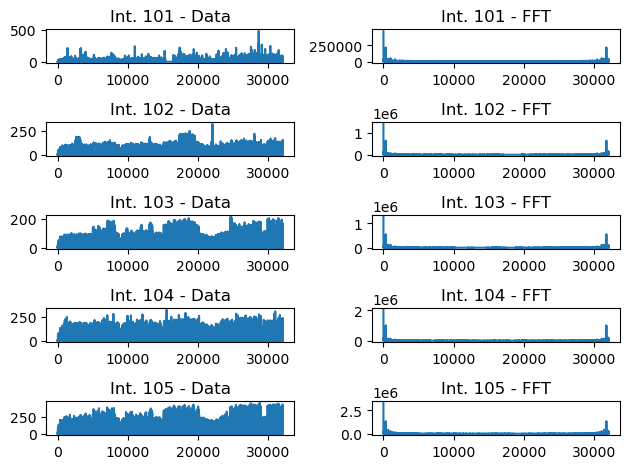

In [9]:
n_plots = 5

def plot_trend_and_fft(data, fft_mag):
    figure, axis = plt.subplots(n_plots, 2)

    for plot, inter in enumerate(range(101, 101 + n_plots)):
        axis[plot, 0].plot(data[:, inter])
        axis[plot, 0].set_title(f'Int. {inter} - Data')

        axis[plot, 1].plot(fft_mag[:, inter])
        axis[plot, 1].set_title(f'Int. {inter} - FFT')

    figure.tight_layout()
    figure.show()

plot_trend_and_fft(mat_q, mat_q_fft_mag)

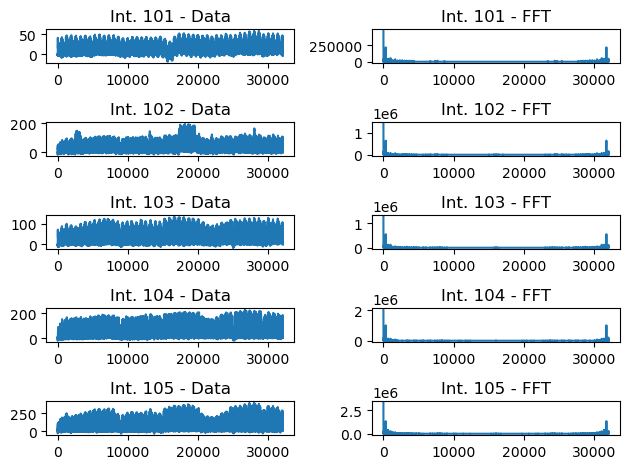

In [10]:
FFT_THRESHOLD = 10000

mat_q_trend_fft = mat_q_fft.clone()
mat_q_trend_fft[mat_q_fft_mag < FFT_THRESHOLD] = 0.0
mat_q_trend_fft_mag = torch.abs(mat_q_trend_fft)

mat_q_trend = torch.fft.ifft(mat_q_trend_fft, dim=0)
torch.save(mat_q_trend, 'mat_q_trend_excluded_missing.pt')

plot_trend_and_fft(torch.real(mat_q_trend), mat_q_trend_fft_mag)

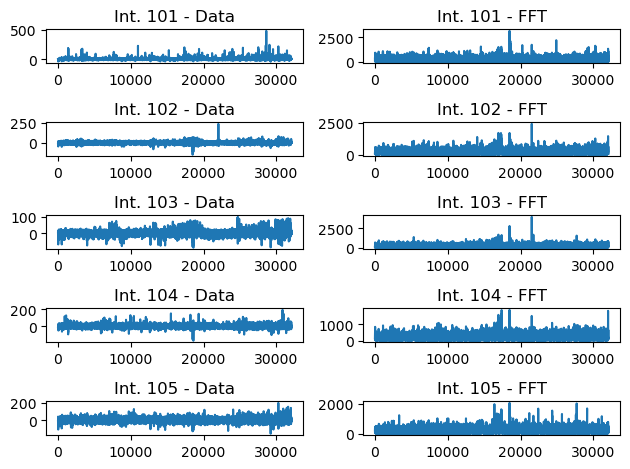

In [11]:
mat_q_resid = mat_q - mat_q_trend
torch.save(mat_q_resid, 'mat_q_resid_excluded_missing.pt')

mat_q_resid_fft_mag = torch.abs(torch.fft.fft(mat_q_resid, dim=1))
plot_trend_and_fft(torch.real(mat_q_resid), mat_q_resid_fft_mag)